# Class OnSource : Take 2 🎬🎬

Description:
====
An instance of class OnSource begins by constructing multiple random waveform datasets, alongside known waveforms spanning a provided parameter space. Afterwards, it computes the cross-correlation and chi-square statistics between all dataset and wave template pairs, organizes the output into a dictory, and saves said dictionary into 'outputfile.json' within the current directory.

Current Issue:
====
- The dictrionary seems to be to large to directly save through the notebook; so i've commented it out. The saving feature seems to work fine from my computer though.
- The codes big, and needs to be commented better; I should probably make a write up for the methods too
- I should proabably parallelize the code with ray
- I need to be read the code for 'unknown unknown' errors
- I should see if I can speed anything up with numpy anywhere
- Off topic, but I still don't know why the below 'methods' section doesn't display tables properly
- the 'exec()' functions could almost surely be used to streamline inputing test statistics/ test waveforms into the function

Methods:
====
1. Constructor: 
 - inputs:
    Most of the constructors inputs are to help define the parameter space and waveform intervals...
    eng. name | lower bound | upper bound| divison 
    ------------ | ------------- | ------------- | -------------
    Amplitude | A0 | Af | N_A
    Frequency | F0 | Ff | N_f
    Gamma | g0 | gf | N_g
    Noise interval|  | T | N_t
    
    Outside of the above, we also have...
    \# of data trials | noise amplitude | foreground/background hald-widths | template width |
    ------------ | ------------- | ------------- | -------------
    trials | b | d | t0_tf
    
 - outputs:
     see class description





2. waveform: 
generates a dataset of noise + injected waveform; the injected waveform has freqeuncy, amplitude, gamma and start time t0 selected randomly from the parameter space. Really just used to construct the required datasets used in the constructor class
 - inputs:
    noise amplitude | interval length | phase | divisions
    ------------- | ------------- | ------------- | -------------
    b | d_end_t | phi | N (=N_t)

 - outputs:
     random parameters | time-step  | time array | dataset waveform
    ------------- | ------------- | ------------- | -------------
    \[f, A, $\gamma$, t_RAN \] | dt | T_full | d




3. template:
Produces a template given a position in parameter space
 - inputs:
    amplitude | frequency | gamma | interval length | time-step
    ------------- | ------------- | ------------- | ------------- | -------------
    A | f | gamma | duration | dt

 - outputs:
     template np array |
    ------------- | 
     A * np.sin(w*t)*np.exp(-gamma*t) |
    
    
    
4. CrossCorrelation
Produces a cross corelation function given a data input and a template in parameter space
 - inputs:
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
     cross correlation |
    ------------- | 
     M |

                                            
    
  
5. ChiSquare: 
Produces chi square at each "slide"
 - inputs:
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
     chi cquare |
    ------------- | 
     C |


6. Rho:
builds provided test-statistic internally

7. modulator:
performs windowing on a given input

8. window:
performs windowing on the internally stored test statistic values
also builds foreground/ background values, and stores them internally as well

9. test_plotter:
plots threshold vs. success-count
    

# Actual Code

In [387]:
import json
import numpy as np
import pylab as pl
import math
import time

class OnSource:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, b, D, trials, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):
       
        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
           key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f & g corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """
        self.trials=trials
        output={}
        for i in range(self.trials):
            output.update({i:[[],[],[],[]]})
        
        
        
        print('initalizing attributes...')
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
        
        # Constructs timestep resolution, and saves t0/tf internally 
        self.dt, self.t0_tf= T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]
        
        
        
        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
       
    
    
        print('starting data/template loop...')
        for i in range(trials):            
            
            # generates data
            temp_AGFT, res, T_full, data=self.waveform(b,d_end_t=T,N=N_t)
            
            self.noise.append(data) 
            output[i][0], output[i][1] = list(temp_AGFT), list(data)  ## stores random a-g-f pair / data set 
            
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation accross parameter space
            for template in self.TEMPLATES_AFG:
            
                CC_dh=list(self.CrossCorrelation(data, template, res))
                CRS_COR.append(CC_dh)
                                            
                CS_dh=list(self.ChiSquare(data, template, res))
                CHI_SQR.append(CS_dh)
            
            #stores base statistics in appropriate attribute/ output
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        #sets output as a attribute
        self.output=output
        
        #saves 'output' as a .json in current working directory.
        '''with open('outputfile', "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    
    
    
            
    # produces data which contains random noise and an injected signal 
    def waveform(self, b, d_end_t=None, phi0=0.0, N=1000):
        
        #calculates random parameters A, f, g
        A_RAN=np.random.randint(0,self.A_LEN)
        G_RAN=np.random.randint(0,self.G_LEN)
        F_RAN=np.random.randint(0,self.F_LEN)
        
        f, A, gamma = self.F_RANGE[F_RAN], self.A_RANGE[A_RAN],  self.G_RANGE[G_RAN]
        
        # calculates injection signal start & end 
        t_RAN=self.dt*np.random.randint(0,self.t_LEN)
        tend=t_RAN+(self.t0_tf)
        
        # Conditional for noise duration If the data-end time is supplied to be too small:
        if (d_end_t is None) or (tend > d_end_t - 10):
            d_end_t = tend + 10
    
        T = np.linspace(t_RAN, tend, N) # Time stamps of signal
        dt = np.mean(np.diff(T)) # figuring out the resolution of the series
    
        t = t_RAN # Initializing the time series at the start time
        t_minus = [] # To populate time stamps prior to the signal start
        while t >= 0: # Making sure that we reach all the way back to zero.
            t = t - dt
            t_minus.append(t)  # Create time spamps from (t0-dt) to 0

        t_minus = np.array(t_minus)[::-1]  # Reverse to be from 0 to t0
        t_minus = t_minus[t_minus >= 0]  # Eliminate numbers less than 0
    
        t_plus = np.arange(tend+dt, d_end_t, dt)  # Time stamps from (tend+dt) to d_end_t, in dt's
    
        T_full = np.hstack((t_minus, T, t_plus))  # Connect time stamps
    
        dev = np.std(np.diff(T_full))  # Standard deviation in dt's of T_full

        w = 2 * np.pi * f  
        y = A*np.sin(w*T + phi0)*np.exp(-gamma*(T-t_RAN))
        
        
        # Padding of signal data
        y_minus = np.zeros_like(t_minus)
        y_plus = np.zeros_like(t_plus)
        y_full = np.hstack((y_minus, y, y_plus))

        noise = -b+2*b*np.random.random(len(T_full))  # Noise!
        
        d = noise + y_full  # Complete Data!
        
        return([f, A, gamma, t_RAN], dt, T_full, d)


    
    
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self):
        #counts number of tempates in parameter space
        PSPACE_LEN=len(self.AFG_PAIR)
    
        #initalizes rho statistic dictionary
        self.RHO={}
    
        #indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i=[]
        
            #indexed to loops through parameter space templates and
            #calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ=np.array(self.cross_cor[i][j][:])
                CS_IJ=np.array(self.chi[i][j][:])
                
                            ##1. function_input="f(CC,CS)"
                            ##2. exec("p="+function_input)
                            ##3. rho_i.append( list( p )) )
                            ##4. ...
                            ##5. profit?
                            
                rho_i.append( list( (CC_IJ/(1+CS_IJ) )) ) 
            
            self.RHO.update({ i : rho_i })
        
        return self.RHO

    
    
    
    
    def modulator(self, rho_ij, D):
       
        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-L%dn,dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        return rho_mod_D
    
    
    
    
    
    def window(self, D):
        
        print('initalizing output...')
        """Build a dictionary of arrays that hold rho off-source/on-source values
        key i: returns ndim-arrays containing rho statistics of dataset_i
            component [0][j]: returns off-source array for template j
            component [1][j]: returns on-source scalar for template j
        """
        self.RHO_MOD={}
        
        for i in range(self.trials):
    
            #gets the length
            TEMP_LEN=len(self.cross_cor[i])
    
            #calculates bg values + fg values
            BG_VALS_IJ=[self.modulator( self.RHO[i][j][:] ,D ) for j in range(TEMP_LEN)]
            
            #seperates fg value from bg value
            T0_2D=math.floor(self.output[i][0][3]/(2*D))
            FG_VAL_IJ=[ BG_VALS_IJ[j].pop(T0_2D) for j in range(TEMP_LEN)]
    
            self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        

        return self.RHO_MOD
    
    
    
    
    def test_plotter(self, T, N):
    
        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]
    
        #sets current threshold value 
        for thrshld in np.linspace(0,T,N):
        
            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if ((N_BG_ij==0) and (FG_ij > thrshld)):
                    
                        PSACE_PAIRS.append(self.AFG_PAIR[j][:])
                    
                        if heat_count==0:
                            succ_count_thrhld+=1
                            heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
    
    
    
    
    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    
    
    
    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
                                            
    
    

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C

# Error (fixed?)
Note: the old error was fixed; The issue was due to trying to store np arrays 
inside the the json file without casting them to lists first.

now it seems the only issue is a jupyter thing its self

# Example run
We run the code over 9 trials, through a parameter space of measure 4*4*4=64
window size is 0.2, injected signal spans to seconds, and total interval spans 5 seconds

In [388]:
x=OnSource(4, 4, 4, 2, 5, 0, 0.2, 9)
#N_A, N_g, N_f, t0_tf, T, b, D, trials

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...


In [389]:
#builds rho statistic
y=x.rho()

In [391]:
#performs modulation/ bg-fg value finding on rho
z=x.window(0.5)

initalizing output...


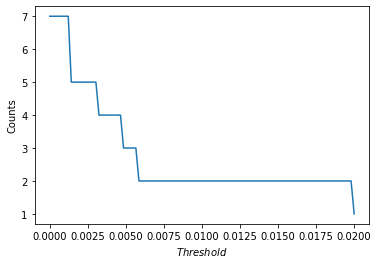

In [394]:
#plots threshold vs. success-count
w=x.test_plotter(0.02,100)

# Extra: modulating function for later (no longer!)
you can ignore this

In [217]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def mod_tester(T,delta,D):
   
    N=math.floor(T/delta)
    print(N)
    TOF=np.linspace(0,T,N)
    dn=math.floor(2*D/delta)
    print(dn)
    L=len(TOF)
    
    wf=np.sin(3*TOF)*np.exp(-TOF)
    print(len(wf))
    maximi=[]
    for i in range(0,L-L%dn,dn):
        print(max(wf[i:i+dn]))
        maximi.append(max(wf[i:i+dn]))
    
    
    plt.plot(TOF,wf)
    plt.plot(np.linspace(0,T,len(maximi)),maximi, 'o')
    
    maxlen=len(np.linspace(0,T,len(maximi)))
    for i in range(maxlen):
        plt.plot([i*2*D,(i+1)*2*D],[maximi[i],maximi[i]])
    plt.xticks(np.linspace(0,T,len(maximi)))
    return maximi

    

# Mod-plot testing

100
20
100
0.6251318104300368
0.07696021062331063
0.00940841699361206
0.0011618449848486247
0.0001438422945455015


[0.6251318104300368,
 0.07696021062331063,
 0.00940841699361206,
 0.0011618449848486247,
 0.0001438422945455015]

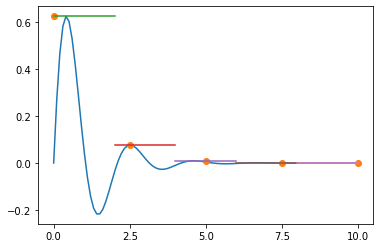

In [220]:
mod_tester(10,.1,1)